In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import boto3

In [3]:
pricing_df = pd.read_csv("../data/ec2-prices.csv")
pricing_df['price_per_ecu_on_demand'] = pricing_df['linux_on_demand_cost_hourly']/pricing_df['compute_units_ecu']
pricing_df.head()

,Name,InstanceType,memory_gb,compute_units_ecu,vcpu,gpus,fpga,enhanced_networking,linux_on_demand_cost_hourly,price_per_ecu_on_demand
0,R3 High-Memory Large,r3.large,15.25,6.5,2,0,0,Yes,0.17,0.026154
1,M4 Large,m4.large,8.00,6.5,2,0,0,Yes,0.10,0.015385
2,R4 High-Memory Large,r4.large,15.25,7.0,2,0,0,Yes,0.13,0.018571
3,C4 High-CPU Large,c4.large,3.75,8.0,2,0,0,Yes,0.10,0.012500
4,General Purpose GPU Extra Large,p2.xlarge,61.00,12.0,4,1,0,Yes,0.90,0.075000


In [4]:
pricing_df.describe()

,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand
count,53.000000,53.000000,53.000000,53.000000,53.000000,50.000000,50.000000
mean,181.033019,65.679245,21.603774,0.603774,0.169811,2.218400,0.032753
std,333.033789,69.828436,24.473172,2.491058,1.104812,3.053673,0.025047
min,3.750000,3.000000,1.000000,0.000000,0.000000,0.070000,0.012045
25%,22.500000,14.000000,4.000000,0.000000,0.000000,0.347500,0.015595
50%,61.000000,35.000000,16.000000,0.000000,0.000000,0.980000,0.022287
75%,160.000000,99.000000,32.000000,0.000000,0.000000,2.735000,0.045246
max,1952.000000,349.000000,128.000000,16.000000,8.000000,14.400000,0.131429


In [5]:
names = pricing_df["InstanceType"].to_dict()

In [6]:
list(names.values())[0:5]

['r3.large', 'm4.large', 'r4.large', 'c4.large', 'p2.xlarge']

In [7]:
client = boto3.client('ec2', region_name='us-west-2')
response =client.describe_spot_price_history(InstanceTypes = list(names.values()),
        ProductDescriptions = ["Linux/UNIX"])

In [7]:
spot_price_history = response['SpotPriceHistory']
spot_history_df = pd.DataFrame(spot_price_history)
spot_history_df.SpotPrice = spot_history_df.SpotPrice.astype(float)

In [8]:
spot_history_df.head()

,AvailabilityZone,InstanceType,ProductDescription,SpotPrice,Timestamp
0,us-west-2c,r4.4xlarge,Linux/UNIX,0.1578,2017-09-11 13:36:23+00:00
1,us-west-2c,c3.2xlarge,Linux/UNIX,0.1023,2017-09-11 13:36:21+00:00
2,us-west-2c,r3.8xlarge,Linux/UNIX,0.6809,2017-09-11 13:36:21+00:00
3,us-west-2c,r4.4xlarge,Linux/UNIX,0.1616,2017-09-11 13:36:21+00:00
4,us-west-2b,c4.8xlarge,Linux/UNIX,0.5606,2017-09-11 13:36:17+00:00


In [9]:
df = spot_history_df.merge(pricing_df, how="inner", on="InstanceType")
df['price_memory_spot'] = df['SpotPrice']/df['memory_gb']
df['price_ecu_spot'] = df['SpotPrice']/df['compute_units_ecu']
df.describe()

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,994.000000,994.000000,1000.000000,1000.000000
mean,0.579126,104.23650,61.046500,18.680000,0.077000,0.006000,1.457535,0.023685,0.004330,0.005947
std,5.954546,167.86273,46.353427,15.307054,0.439618,0.077266,1.612221,0.013906,0.003744,0.017157
min,0.009000,3.75000,3.000000,1.000000,0.000000,0.000000,0.070000,0.012045,0.000683,0.002259
25%,0.097700,30.00000,27.000000,8.000000,0.000000,0.000000,0.420000,0.015273,0.002111,0.003433
50%,0.248150,60.50000,52.000000,16.000000,0.000000,0.000000,0.900000,0.020000,0.003361,0.004183
75%,0.427425,122.00000,104.000000,32.000000,0.000000,0.000000,1.680000,0.025577,0.006050,0.006482
max,133.380000,1952.00000,349.000000,128.000000,8.000000,1.000000,13.340000,0.088571,0.068330,0.382178


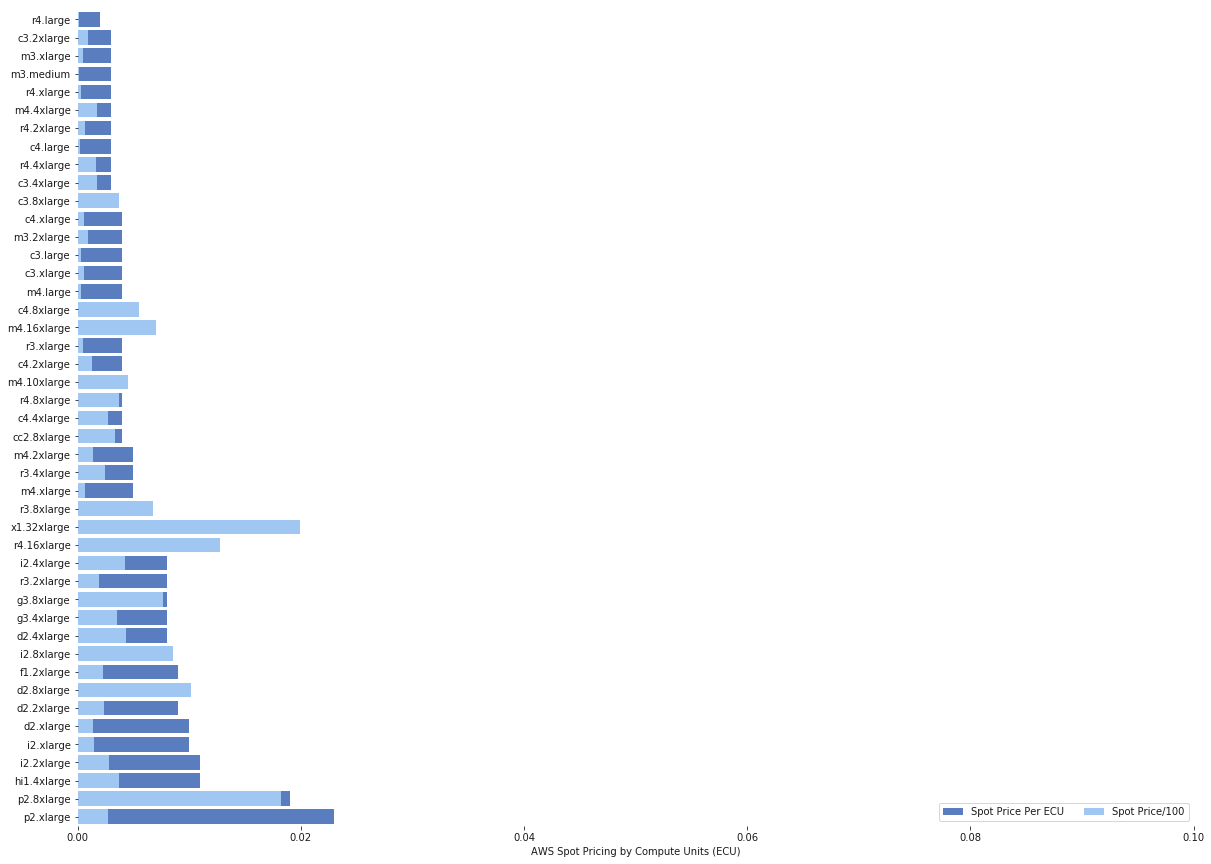

In [10]:
df_median = df.groupby("InstanceType").median()
df_median["InstanceType"] = df_median.index
df_median["price_ecu_spot"] = df_median.price_ecu_spot.round(3)
df_median["divide_SpotPrice"] = df_median.SpotPrice/100
df_median.sort_values("price_ecu_spot", inplace=True)
plt.subplots(figsize=(20,15))
ax = plt.axes()
sns.set_color_codes("muted")
sns.barplot(x="price_ecu_spot", y="InstanceType", data=df_median,
            label="Spot Price Per ECU", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="divide_SpotPrice", y="InstanceType", data=df_median,
            label="Spot Price/100", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .1), ylabel="",
       xlabel="AWS Spot Pricing by Compute Units (ECU)")
sns.despine(left=True, bottom=True)

In [11]:
numerical_df = df_median.loc[:,["price_ecu_spot", "price_memory_spot"]]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(numerical_df)
scaler.transform(numerical_df)
k_means = KMeans(n_clusters=3)
kmeans = k_means.fit(scaler.transform(numerical_df))
df_median["cluster"]=kmeans.labels_
df_median

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot,InstanceType,divide_SpotPrice,cluster
InstanceType,,,,,,,,,,,,,
r4.large,0.01710,15.25,7.0,2,0,0,0.13,0.018571,0.001121,0.002,r4.large,0.000171,0
c3.2xlarge,0.09750,15.00,28.0,8,0,0,0.42,0.015000,0.006500,0.003,c3.2xlarge,0.000975,1
m3.xlarge,0.04460,15.00,13.0,4,0,0,0.27,0.020769,0.002973,0.003,m3.xlarge,0.000446,0
m3.medium,0.00905,3.75,3.0,1,0,0,0.07,0.023333,0.002413,0.003,m3.medium,0.000090,0
r4.xlarge,0.03430,30.50,13.5,4,0,0,0.27,0.020000,0.001125,0.003,r4.xlarge,0.000343,0
m4.4xlarge,0.17650,64.00,53.5,16,0,0,0.80,0.014953,0.002758,0.003,m4.4xlarge,0.001765,0
r4.2xlarge,0.06930,61.00,27.0,8,0,0,0.53,0.019630,0.001136,0.003,r4.2xlarge,0.000693,0
c4.large,0.02205,3.75,8.0,2,0,0,0.10,0.012500,0.005880,0.003,c4.large,0.000220,1
r4.4xlarge,0.16310,122.00,53.0,16,0,0,1.06,0.020000,0.001337,0.003,r4.4xlarge,0.001631,0


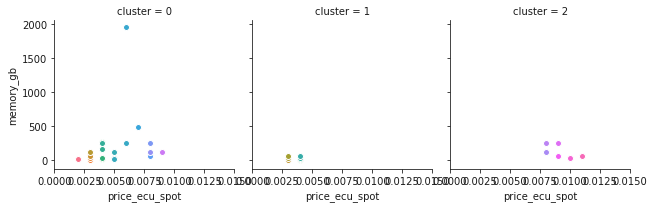

In [12]:
g = sns.FacetGrid(df_median, col="cluster",  hue="InstanceType")
g = g.map(plt.scatter, "price_ecu_spot", "memory_gb", edgecolor="w")
g.set(xlim=(0, .015))